In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

from imutils import paths
from pathlib import Path
import os
import sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms

In [15]:
# Script runtime options
model = 'resnet152'
data_root_dir = '../data_nabirds'
model_root_dir = '../nabirds_models'
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images_sorted')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'na_birds_{}_full.pth'.format(model))

In [7]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [11]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}

class_labels = load_class_names(dataset_path=data_root_dir)
class_names = []
for class_id in image_datasets['test'].classes:
    class_names.append( '{} - {}'.format(class_id, class_labels[str(int(class_id))]) )
    
num_classes = len(class_names)

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print('{} :: {} :: {}'.format(i_class,class_name,(np.array(image_datasets['test'].targets) == i_class).sum()))


Number of data
test  size::  24633  images

Number of classes::  555
0 :: 0295 - Common Eider (Adult male) :: 29
1 :: 0296 - Long-tailed Duck (Winter male) :: 30
2 :: 0297 - Ruddy Duck (Breeding male) :: 38
3 :: 0298 - Swainson's Hawk (Dark morph ) :: 30
4 :: 0299 - Red-tailed Hawk (Light morph adult) :: 60
5 :: 0313 - Snow Goose (White morph) :: 26
6 :: 0314 - Wood Duck (Breeding male) :: 60
7 :: 0315 - Gadwall (Breeding male) :: 56
8 :: 0316 - American Wigeon (Breeding male) :: 45
9 :: 0317 - Mallard (Breeding male) :: 60
10 :: 0318 - Blue-winged Teal (Male) :: 42
11 :: 0319 - Cinnamon Teal (Male) :: 55
12 :: 0320 - Northern Shoveler (Breeding male) :: 60
13 :: 0321 - Northern Pintail (Breeding male) :: 42
14 :: 0322 - Green-winged Teal (Male) :: 41
15 :: 0323 - Canvasback (Breeding male) :: 43
16 :: 0324 - Redhead (Breeding male) :: 27
17 :: 0325 - Ring-necked Duck (Breeding male) :: 44
18 :: 0326 - Greater Scaup (Breeding male) :: 43
19 :: 0327 - Lesser Scaup (Breeding male) :: 44


In [12]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


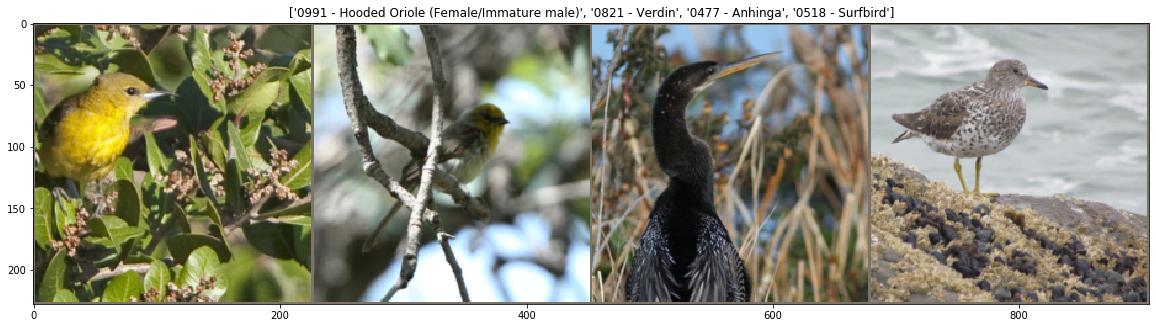

In [13]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [16]:
# Load the best model from file
model_ = torch.load(model_file)

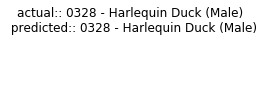

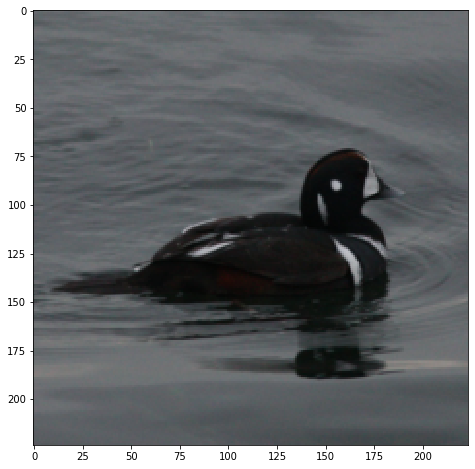

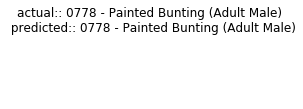

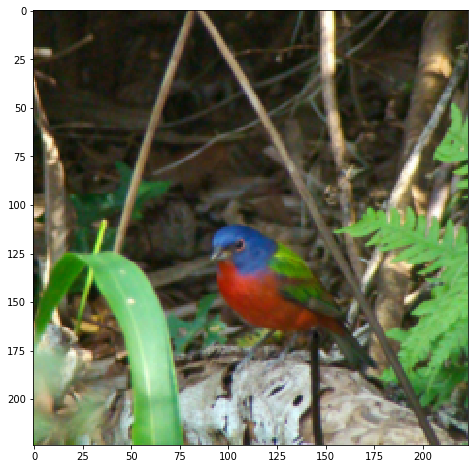

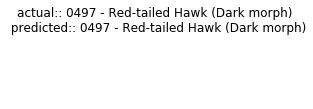

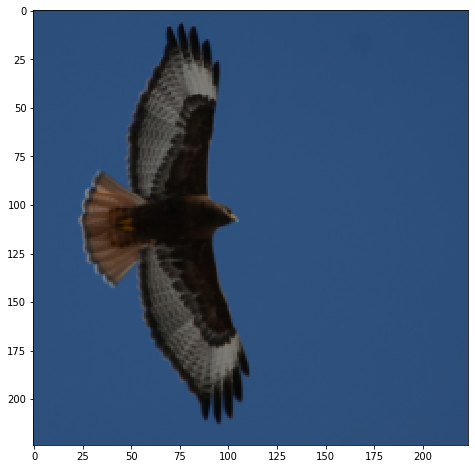

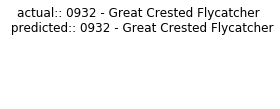

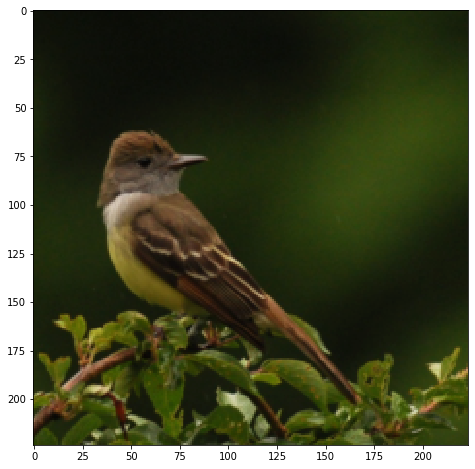

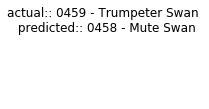

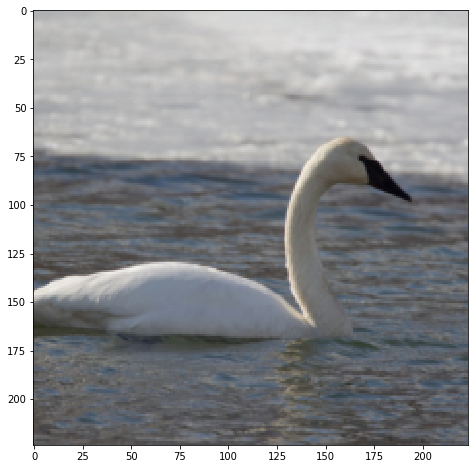

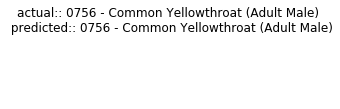

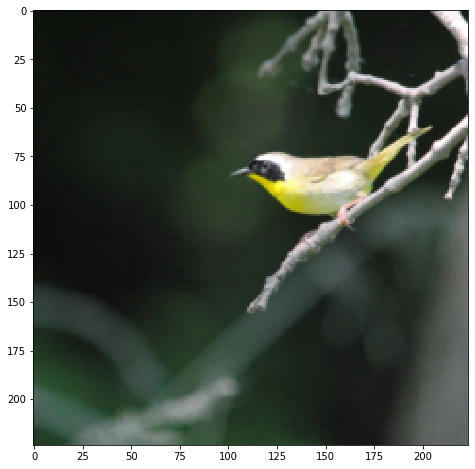

In [17]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [18]:
# Load model training history
history = unpickle(model_history)

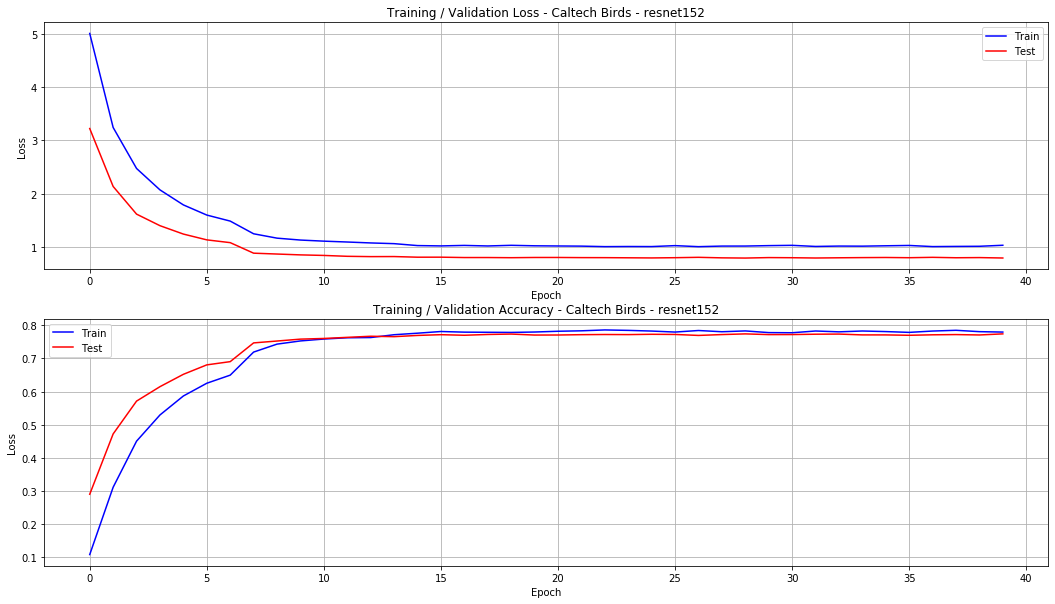

In [19]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model))
plt.legend()

plt.show()

In [20]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print('{}..'.format(i), end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
            scores_pred = outputs.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))
            scores_pred= np.concatenate((scores_pred,outputs.cpu().numpy()))

print('Complete.')

results_dict = {'labels truth' : labels_truth, 'labels pred' : labels_pred, 'scores pred' : scores_pred}

Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..1450..1475..1500..1525..1550..1575..1600..1625..1650..1675..1700..1725..1750..1775..1800..1825..1850..1875..1900..1925..1950..1975..2000..2025..2050..2075..2100..2125..2150..2175..2200..2225..2250..2275..2300..2325..2350..2375..2400..2425..2450..2475..2500..2525..2550..2575..2600..2625..2650..2675..2700..2725..2750..2775..2800..2825..2850..2875..2900..2925..2950..2975..3000..3025..3050..3075..3100..3125..3150..3175..3200..3225..3250..3275..3300..3325..3350..3375..3400..3425..3450..3475..3500..3525..3550..3575..3600..3625..3650..3675..3700..3725..3750..3775..3800..3825..3850..3875..3900..3925..3950..3975..4000..4025..4050..4075..4100..4125..4150..4175..420

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [22]:
print(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names))

                                                                  precision    recall  f1-score   support

                                0295 - Common Eider (Adult male)       0.93      0.90      0.91        29
                           0296 - Long-tailed Duck (Winter male)       0.97      0.93      0.95        30
                               0297 - Ruddy Duck (Breeding male)       0.95      0.95      0.95        38
                            0298 - Swainson's Hawk (Dark morph )       0.45      0.33      0.38        30
                      0299 - Red-tailed Hawk (Light morph adult)       0.77      0.57      0.65        60
                                 0313 - Snow Goose (White morph)       0.60      0.35      0.44        26
                                0314 - Wood Duck (Breeding male)       0.94      0.97      0.95        60
                                  0315 - Gadwall (Breeding male)       0.74      0.89      0.81        56
                          0316 - American Wig

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
class_report_df = pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))
class_report_df

0295 - Common Eider (Adult male)  \
precision                          0.928571   
recall                             0.896552   
f1-score                           0.912281   
support                           29.000000   

           0296 - Long-tailed Duck (Winter male)  \
precision                               0.965517   
recall                                  0.933333   
f1-score                                0.949153   
support                                30.000000   

           0297 - Ruddy Duck (Breeding male)  \
precision                           0.947368   
recall                              0.947368   
f1-score                            0.947368   
support                            38.000000   

           0298 - Swainson's Hawk (Dark morph )  \
precision                              0.454545   
recall                                 0.333333   
f1-score                               0.384615   
support                               30.000000   

           0299 - Red-tailed Hawk (Light morph adult)  \
precision                                    0.772727   
recall                                       0.566667   
f1-score                                     0.653846   
support                                     60.000000   

           0313 - Snow Goose (White morph)  0314 - Wood Duck (Breeding male)  \
precision                         0.600000                          0.935484   
recall                            0.346154                          0.966667   
f1-score                          0.439024                          0.950820   
support                          26.000000                         60.000000   

           0315 - Gadwall (Breeding male)  \
precision                        0.735294   
recall                           0.892857   
f1-score                         0.806452   
support                         56.000000   

           0316 - American Wigeon (Breeding male)  \
precision                                0.857143   
recall                                   0.933333   
f1-score                                 0.893617   
support                                 45.000000   

           0317 - Mallard (Breeding male)  ...  \
precision                        0.932203  ...   
recall                           0.916667  ...   
f1-score                         0.924370  ...   
support                         60.000000  ...   

           1004 - Vermilion Flycatcher (Female, immature)  \
precision                                        0.916667   
recall                                           0.611111   
f1-score                                         0.733333   
support                                         36.000000   

           1005 - European Starling (Juvenile)  \
precision                             0.821429   
recall                                0.657143   
f1-score                              0.730159   
support                              35.000000   

           1006 - Fox Sparrow (Thick-billed/Slate-colored)  \
precision                                              0.0   
recall                                                 0.0   
f1-score                                               0.0   
support                                               16.0   

           1007 - Summer Tanager (Immature Male)  \
precision                               0.909091   
recall                                  0.588235   
f1-score                                0.714286   
support                                17.000000   

           1008 - Orchard Oriole (Female/Juvenile)  \
precision                                 0.435897   
recall                                    0.653846   
f1-score                                  0.523077   
support                                  26.000000   

           1009 - Yellow-rumped Warbler (Winter/juvenile Audubon's)  \
precision                                           0.628571          
recall                                       

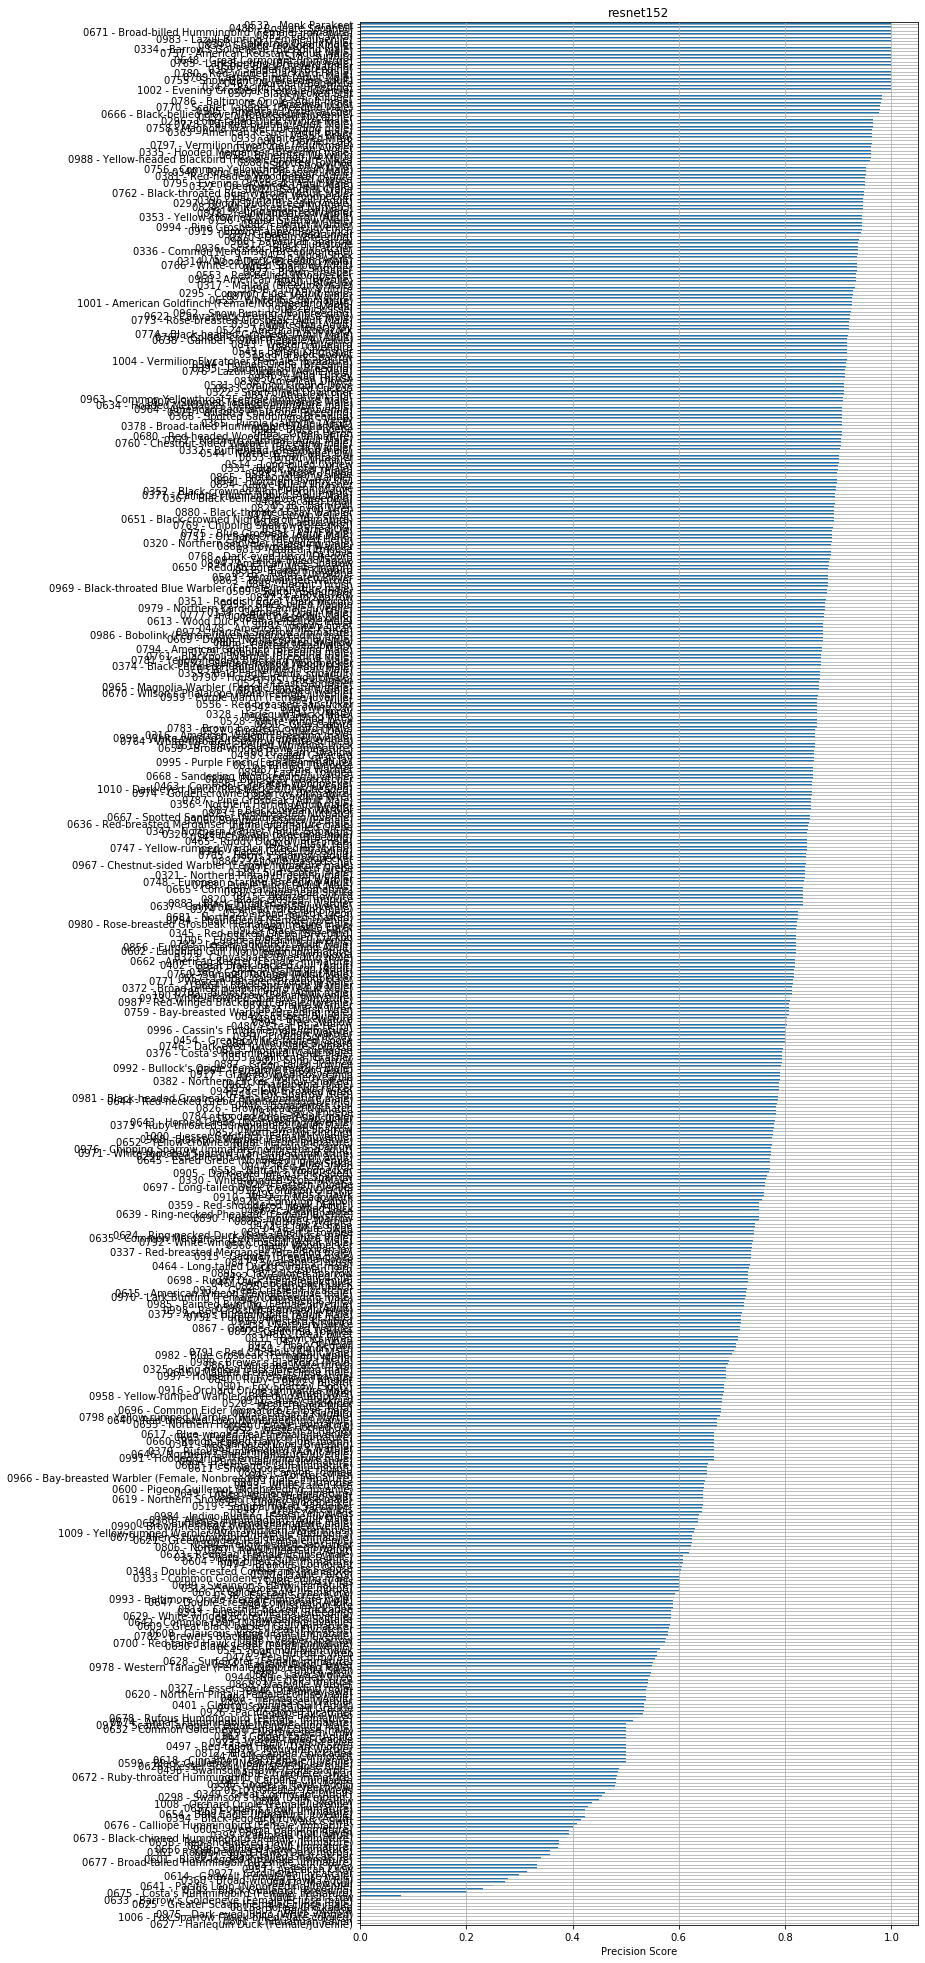

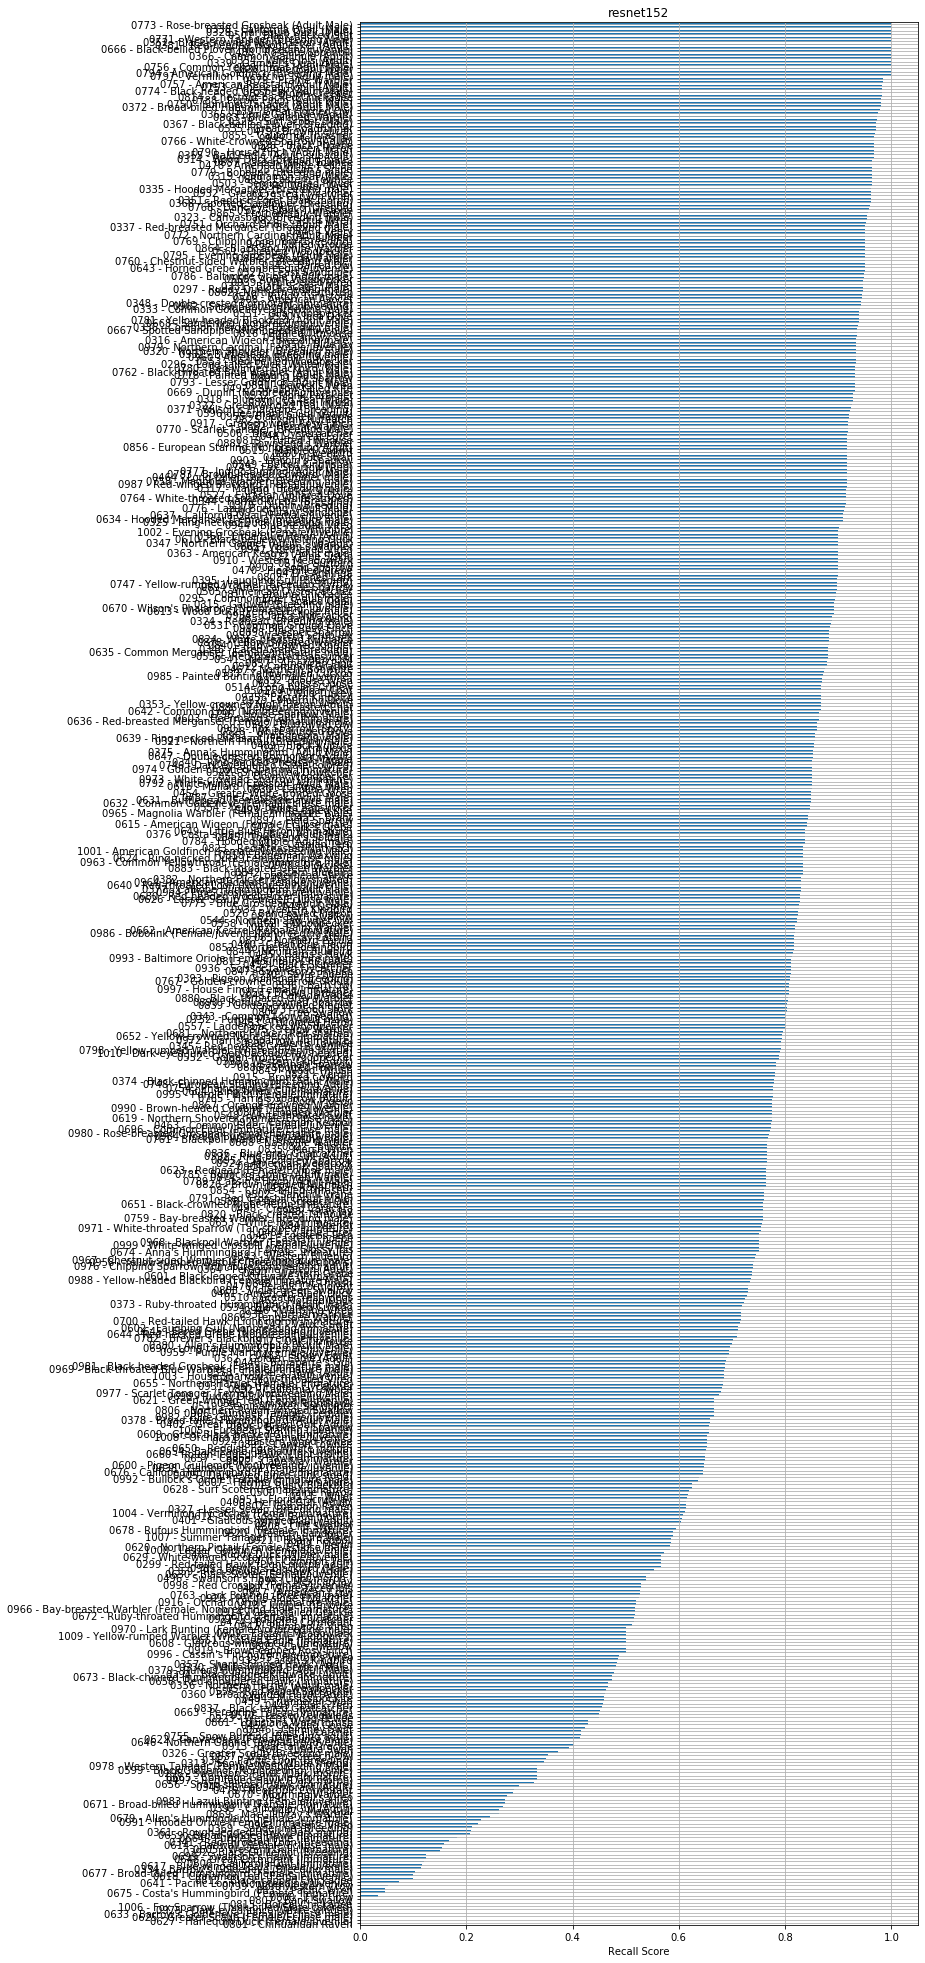

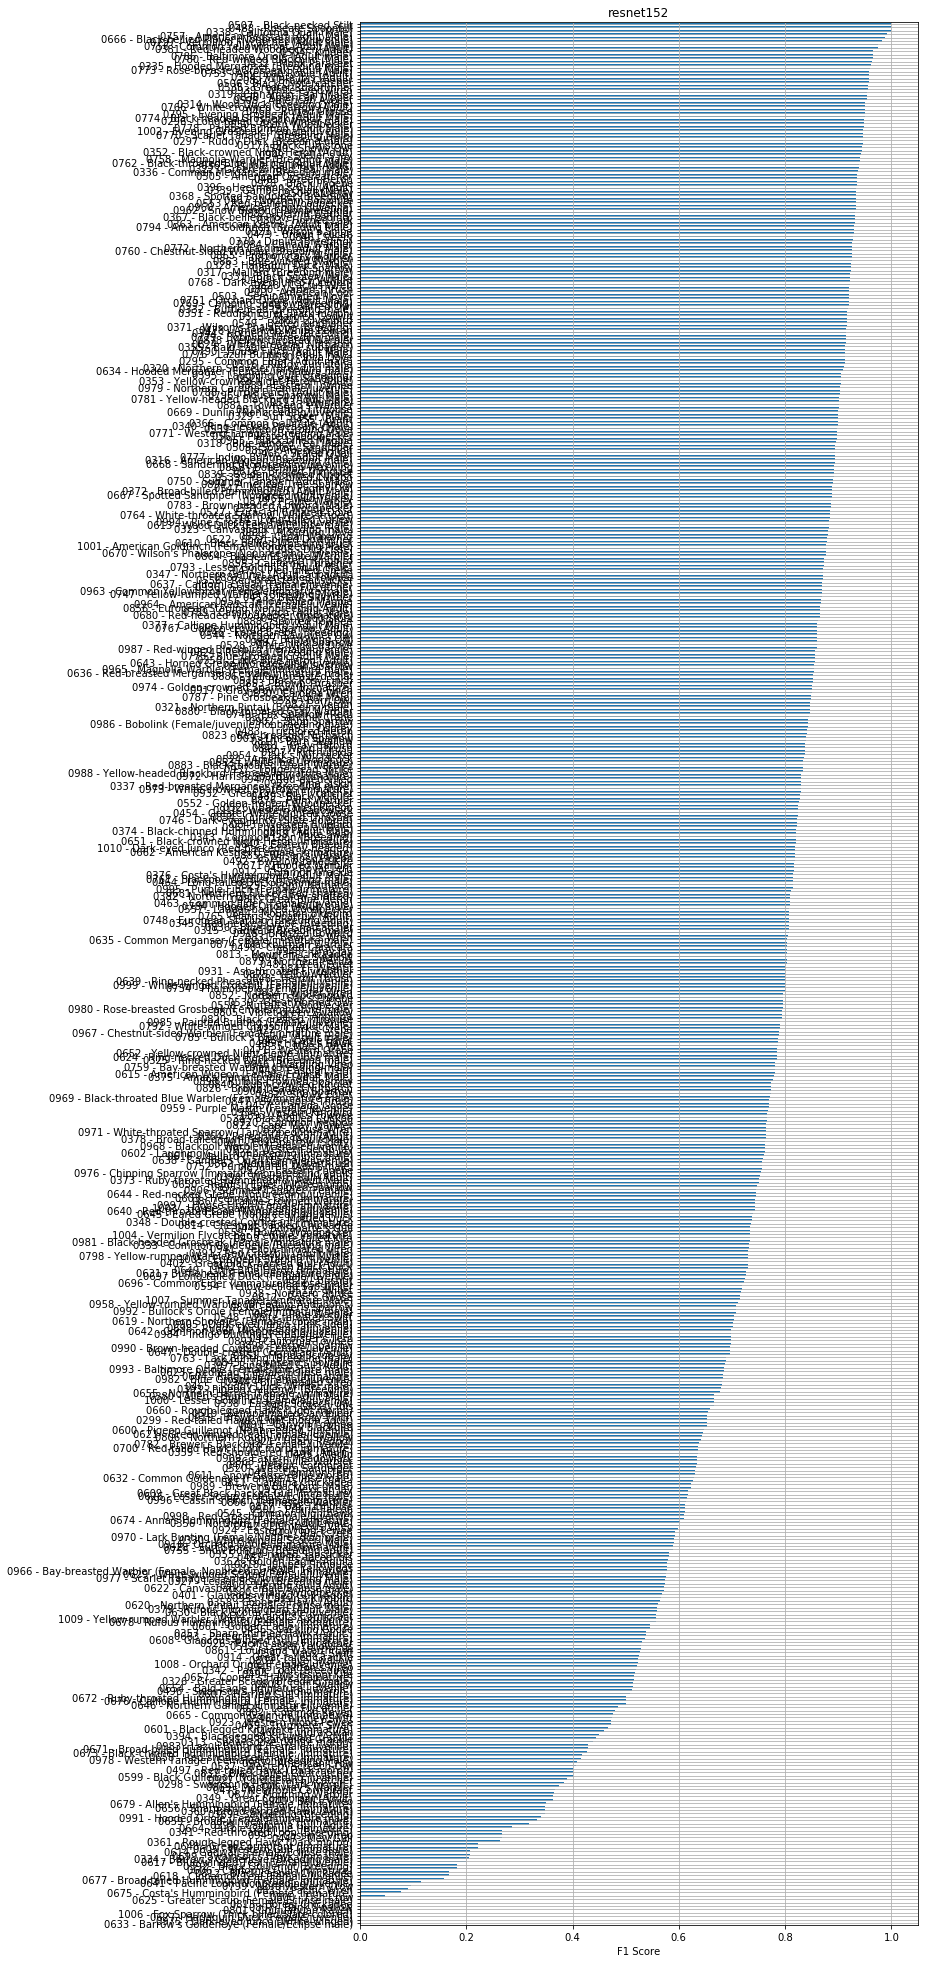

In [24]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [25]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

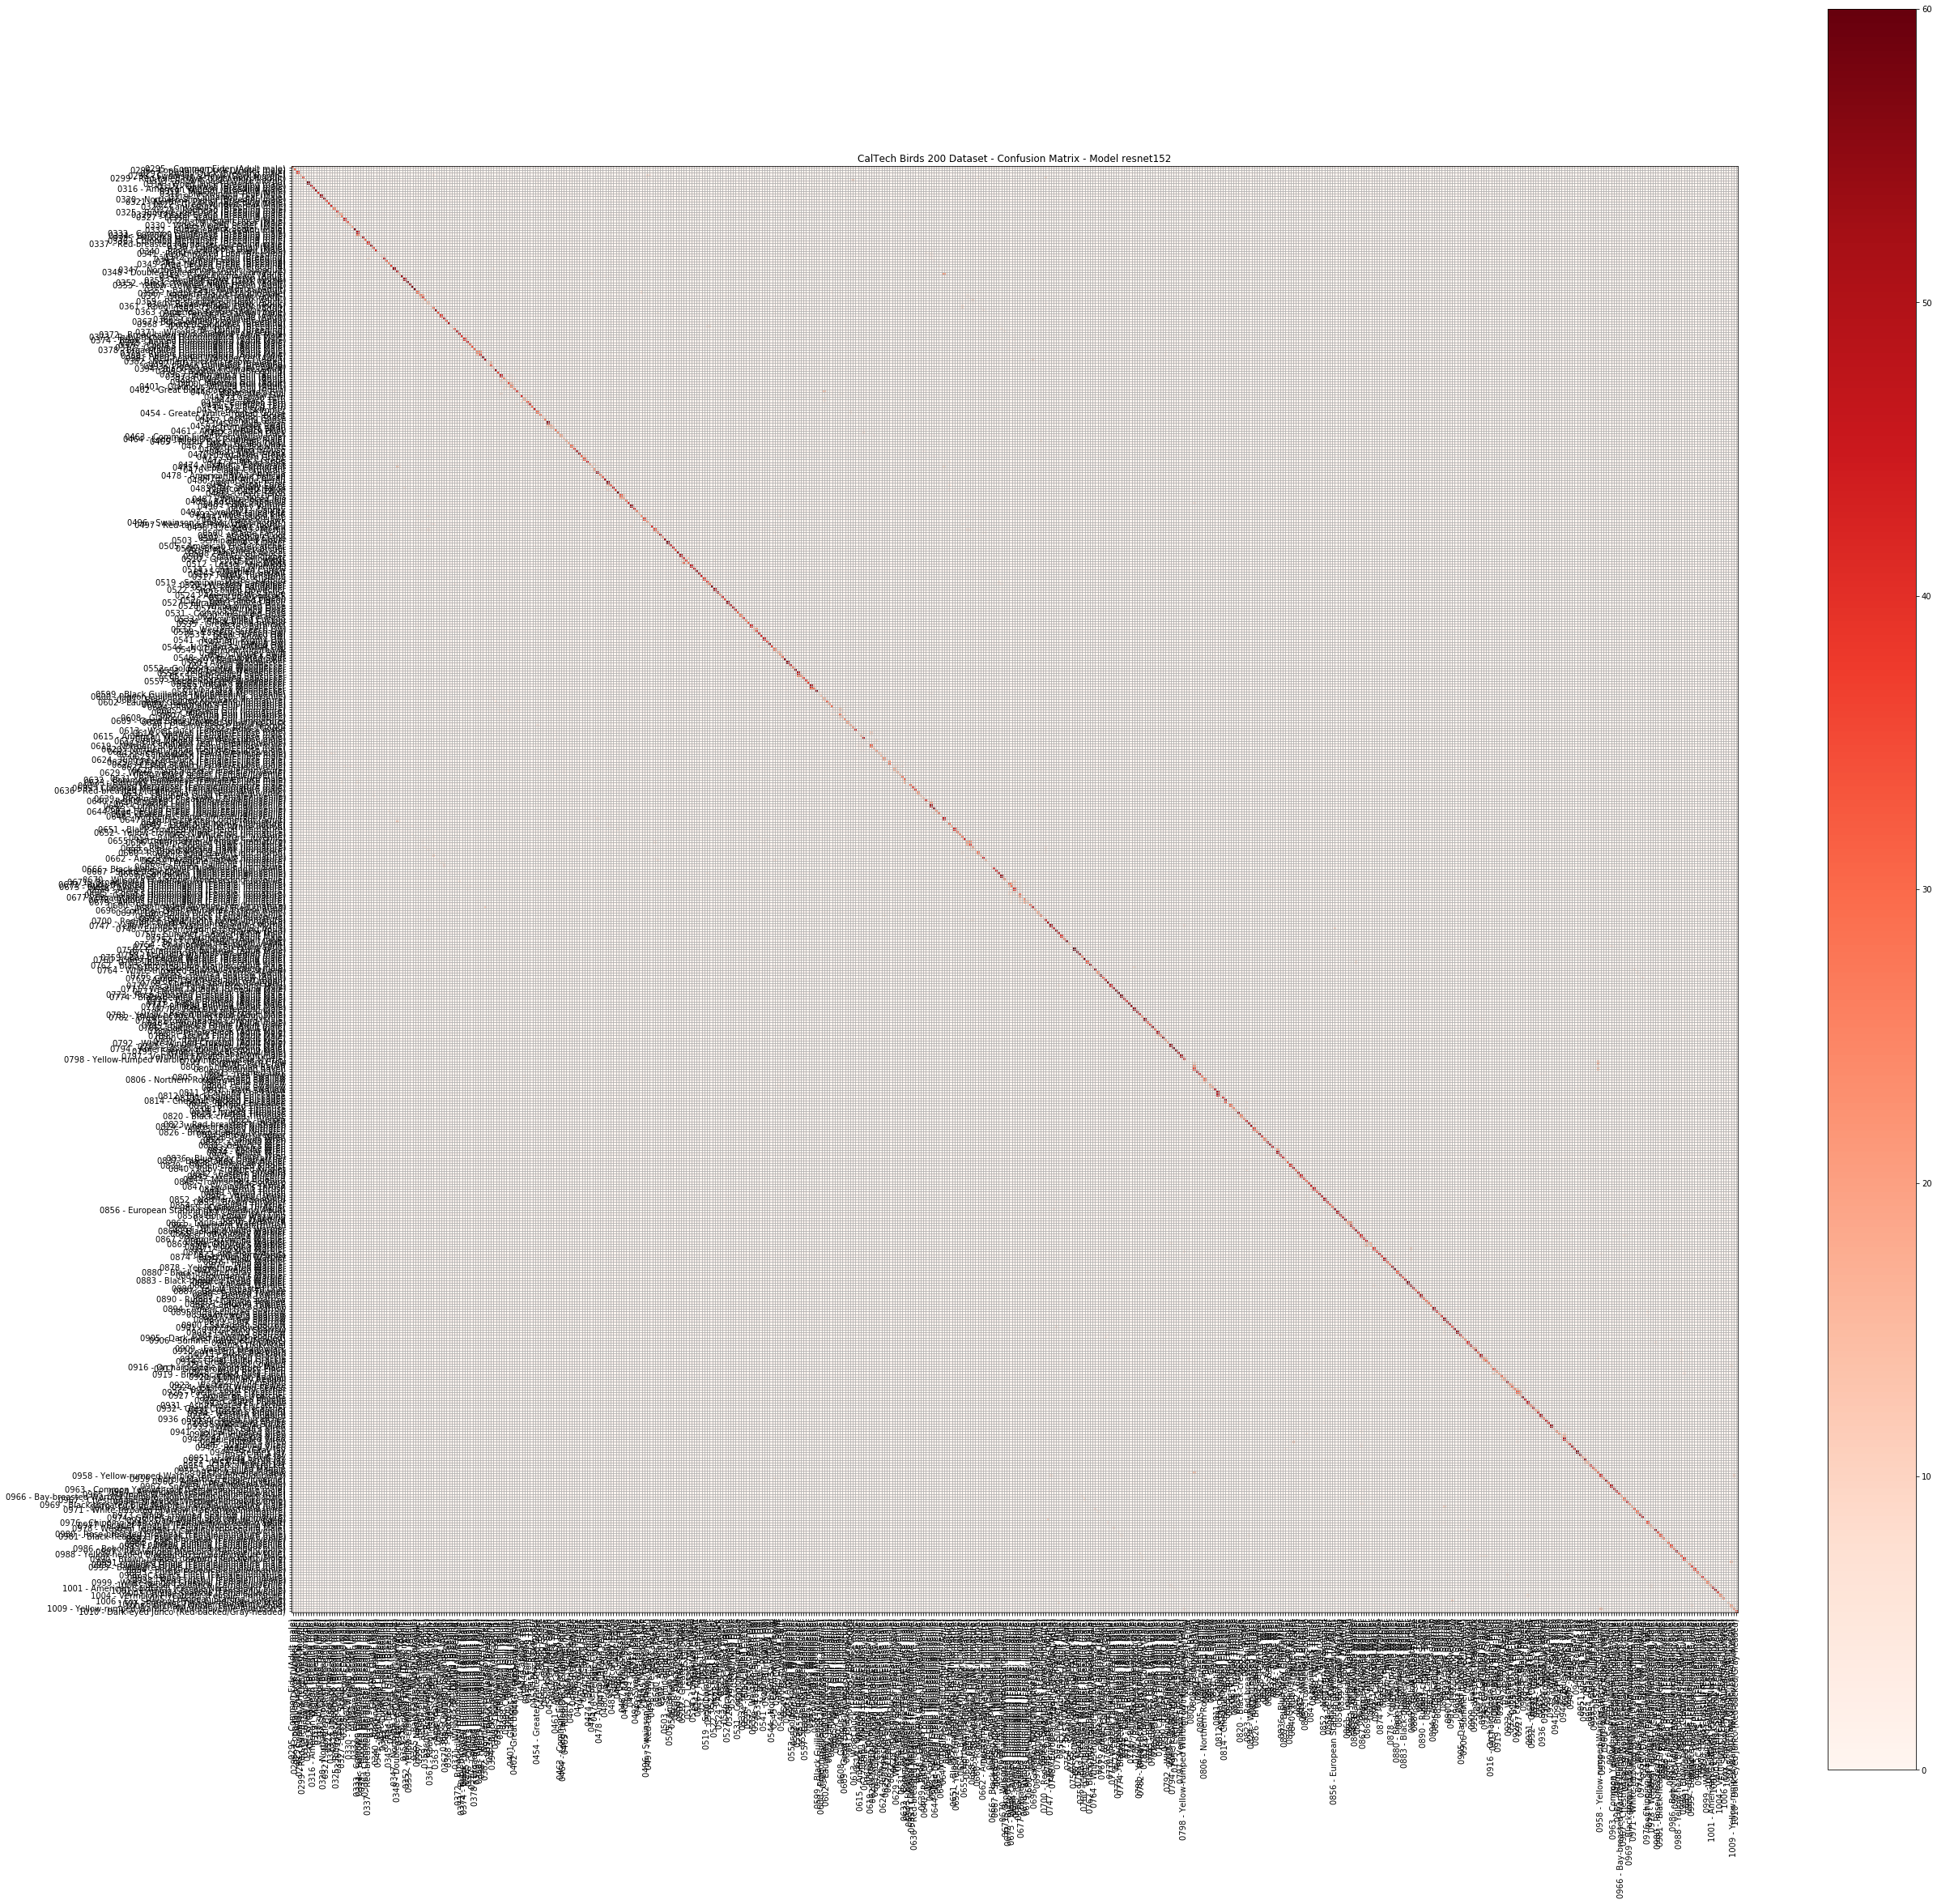

In [26]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [27]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))
save_pickle(pkl_object=results_dict, fname=os.path.join(output_dir,'model_results.pkl'))

In [28]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [29]:
results_dict.keys()

dict_keys(['labels truth', 'labels pred', 'scores pred'])

In [30]:
results_dict['scores pred'].shape

(24633, 555)

In [31]:
misclass_scores = []
for i in range(results_dict['scores pred'].shape[0]):
    if results_dict['labels truth'][i] != results_dict['labels pred'][i]:
        misclass_scores.append( 
            {
                'label truth' : results_dict['labels truth'][i],
                'label pred' : results_dict['labels pred'][i],
                'scores' : softmax(results_dict['scores pred'][i,:])
            }
        )

In [32]:
pd.DataFrame(misclass_scores)

label truth  label pred  \
0             296         190   
1             155         162   
2             124         121   
3             324         109   
4             245         286   
...           ...         ...   
5562          439         531   
5563           75          76   
5564           41         250   
5565           87         210   
5566          457         533   

                                                 scores  
0     [5.2032487e-06, 1.9161846e-05, 2.2182394e-05, ...  
1     [6.077137e-07, 1.5076829e-07, 5.196451e-06, 1....  
2     [0.000121118675, 1.4406194e-05, 1.0007493e-06,...  
3     [5.7258952e-05, 2.3460916e-05, 0.00013396368, ...  
4     [0.0008810812, 0.012969905, 4.3670574e-05, 0.0...  
...                                                 ...  
5562  [1.128182e-06, 8.3893735e-07, 2.2259596e-06, 3...  
5563  [8.640432e-05, 0.0001465641, 4.832795e-08, 1.9...  
5564  [1.51280465e-05, 9.967332e-09, 2.098964e-08, 6...  
5565  [2.9138062e-07, 2.458155e-06, 2.1366546e-09, 1...  
5566  [2.5736742e-06, 2.1016749e-07, 7.2396483e-07, ...  

[5567 rows x 3 columns]

In [33]:
misclass_scores_array = []
for m in misclass_scores:
    misclass_scores_array.append( m['scores'] )
misclass_scores_array = np.asarray(misclass_scores_array)

In [34]:
misclass_scores_array.shape

(5567, 555)

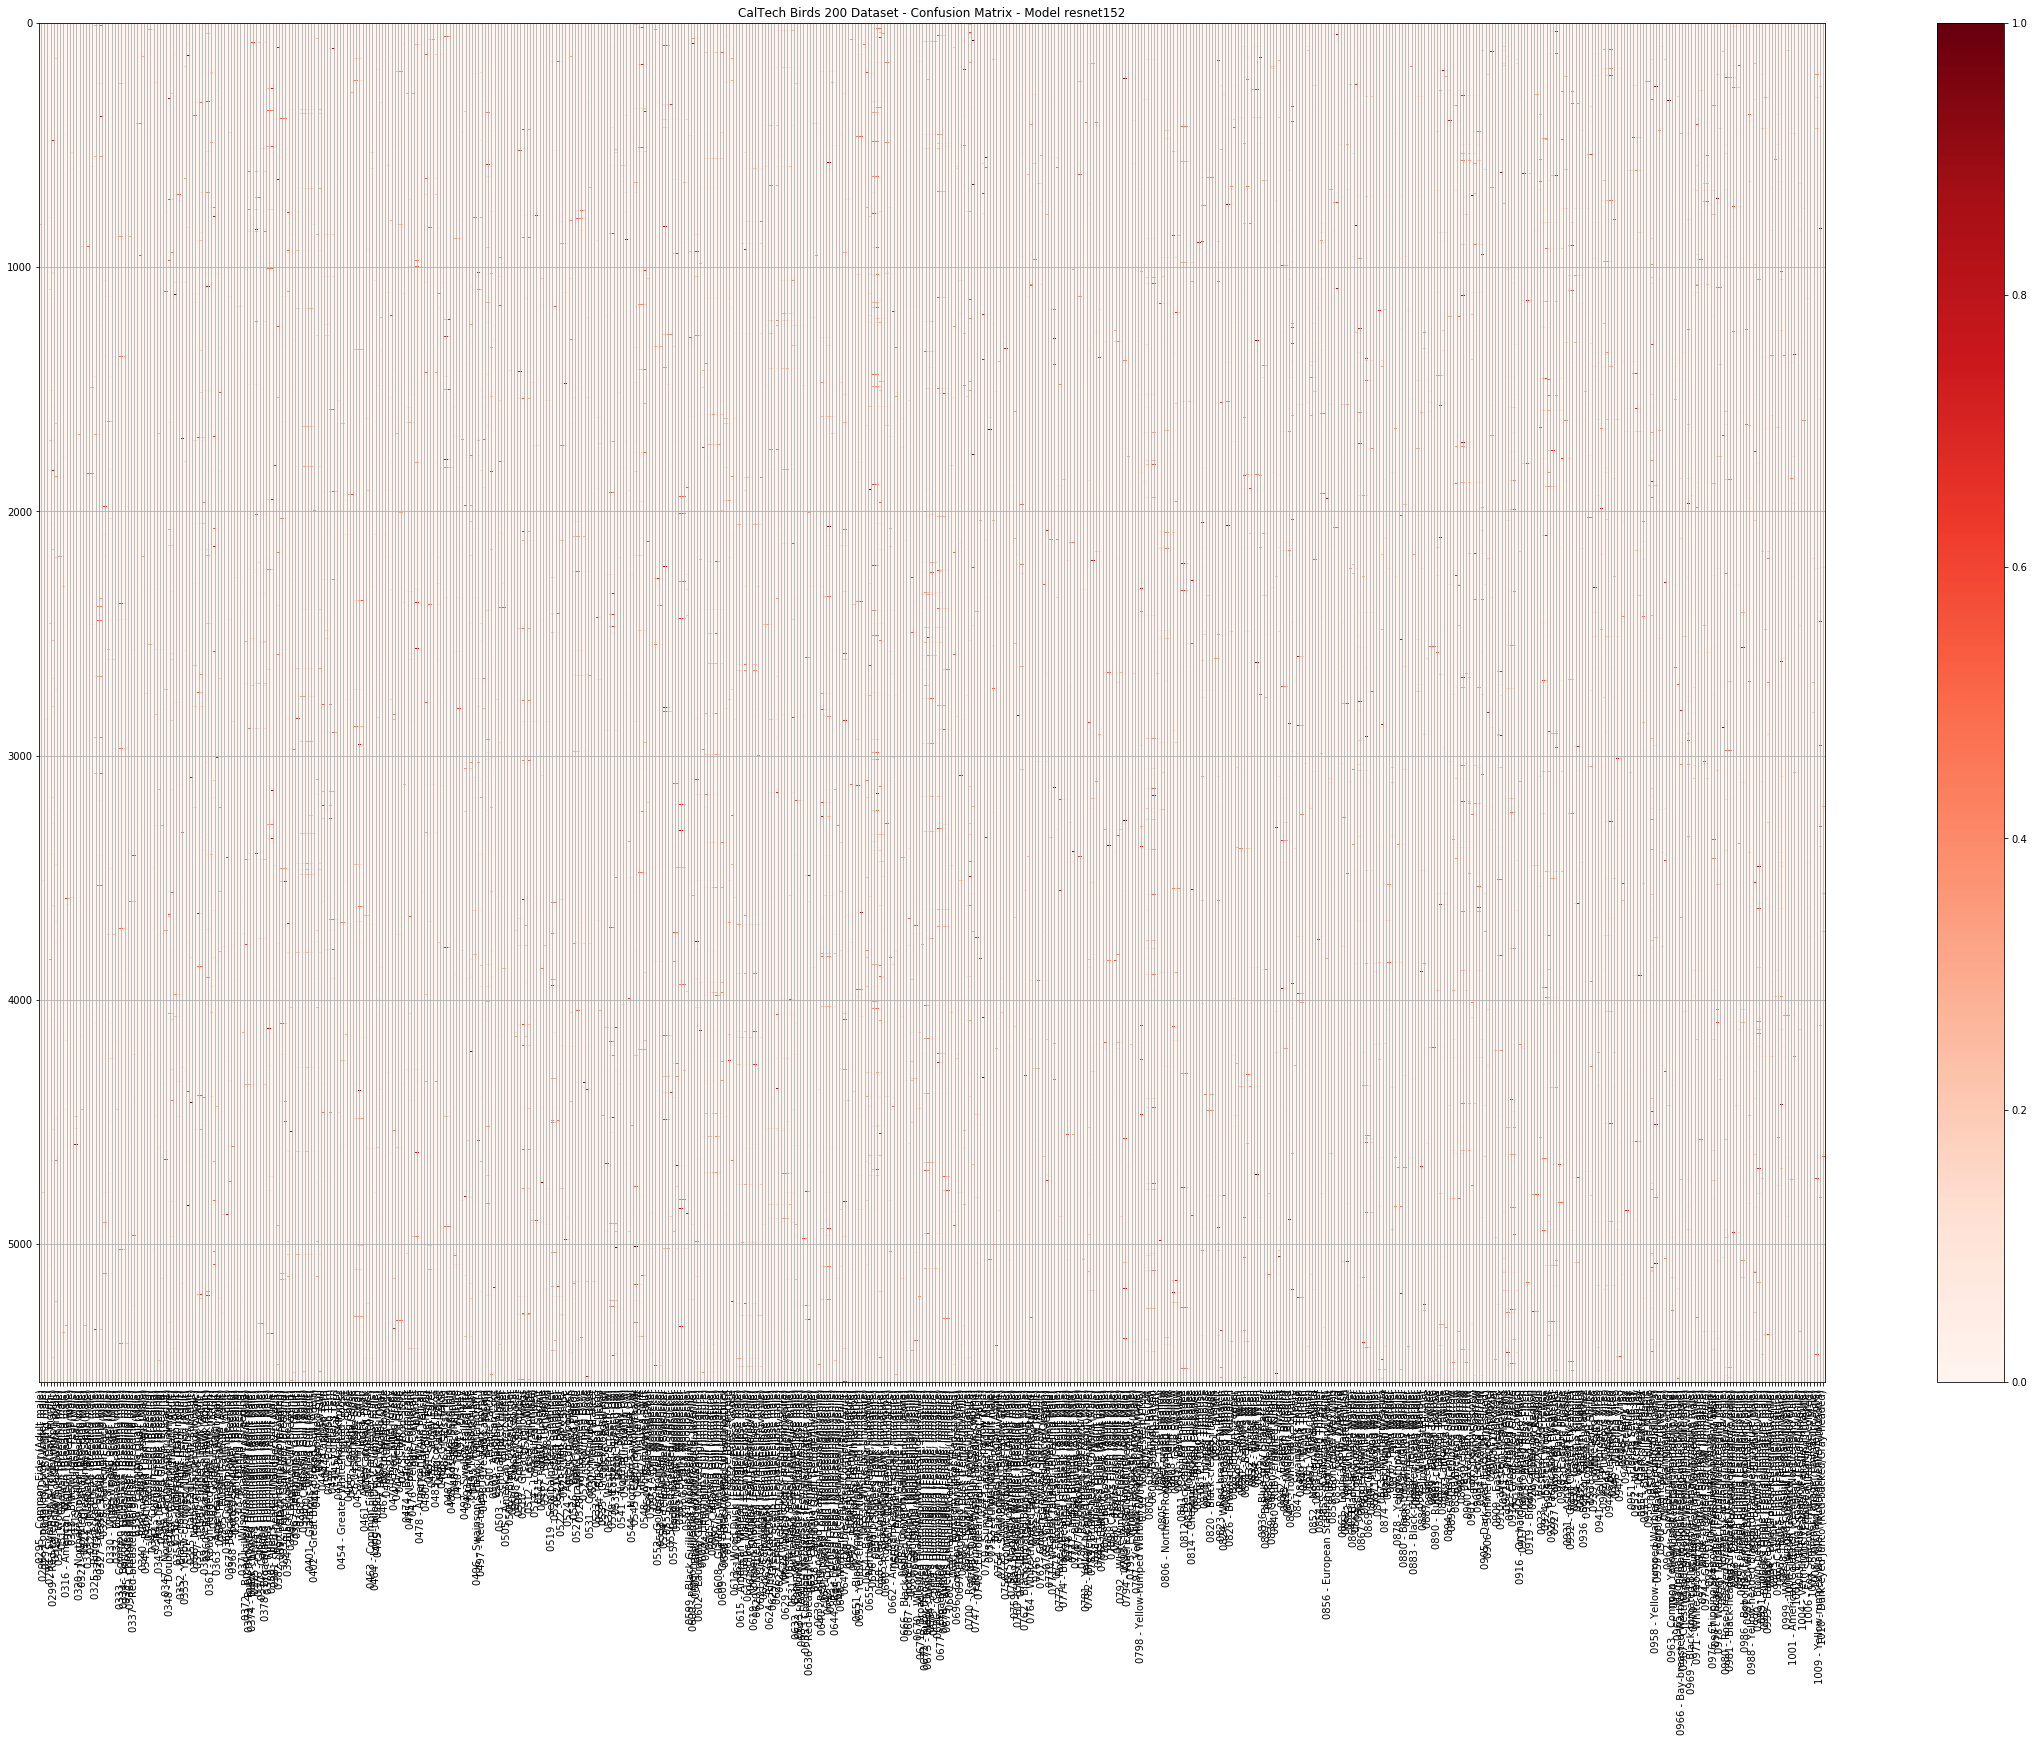

In [35]:
plt.figure(figsize=(40,25))
plt.imshow(misclass_scores_array, cmap='Reds', aspect='auto')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
#plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.clim([0,1.0])
plt.show()

In [36]:
test_img_i = 5

results = softmax(results_dict['scores pred'][test_img_i])

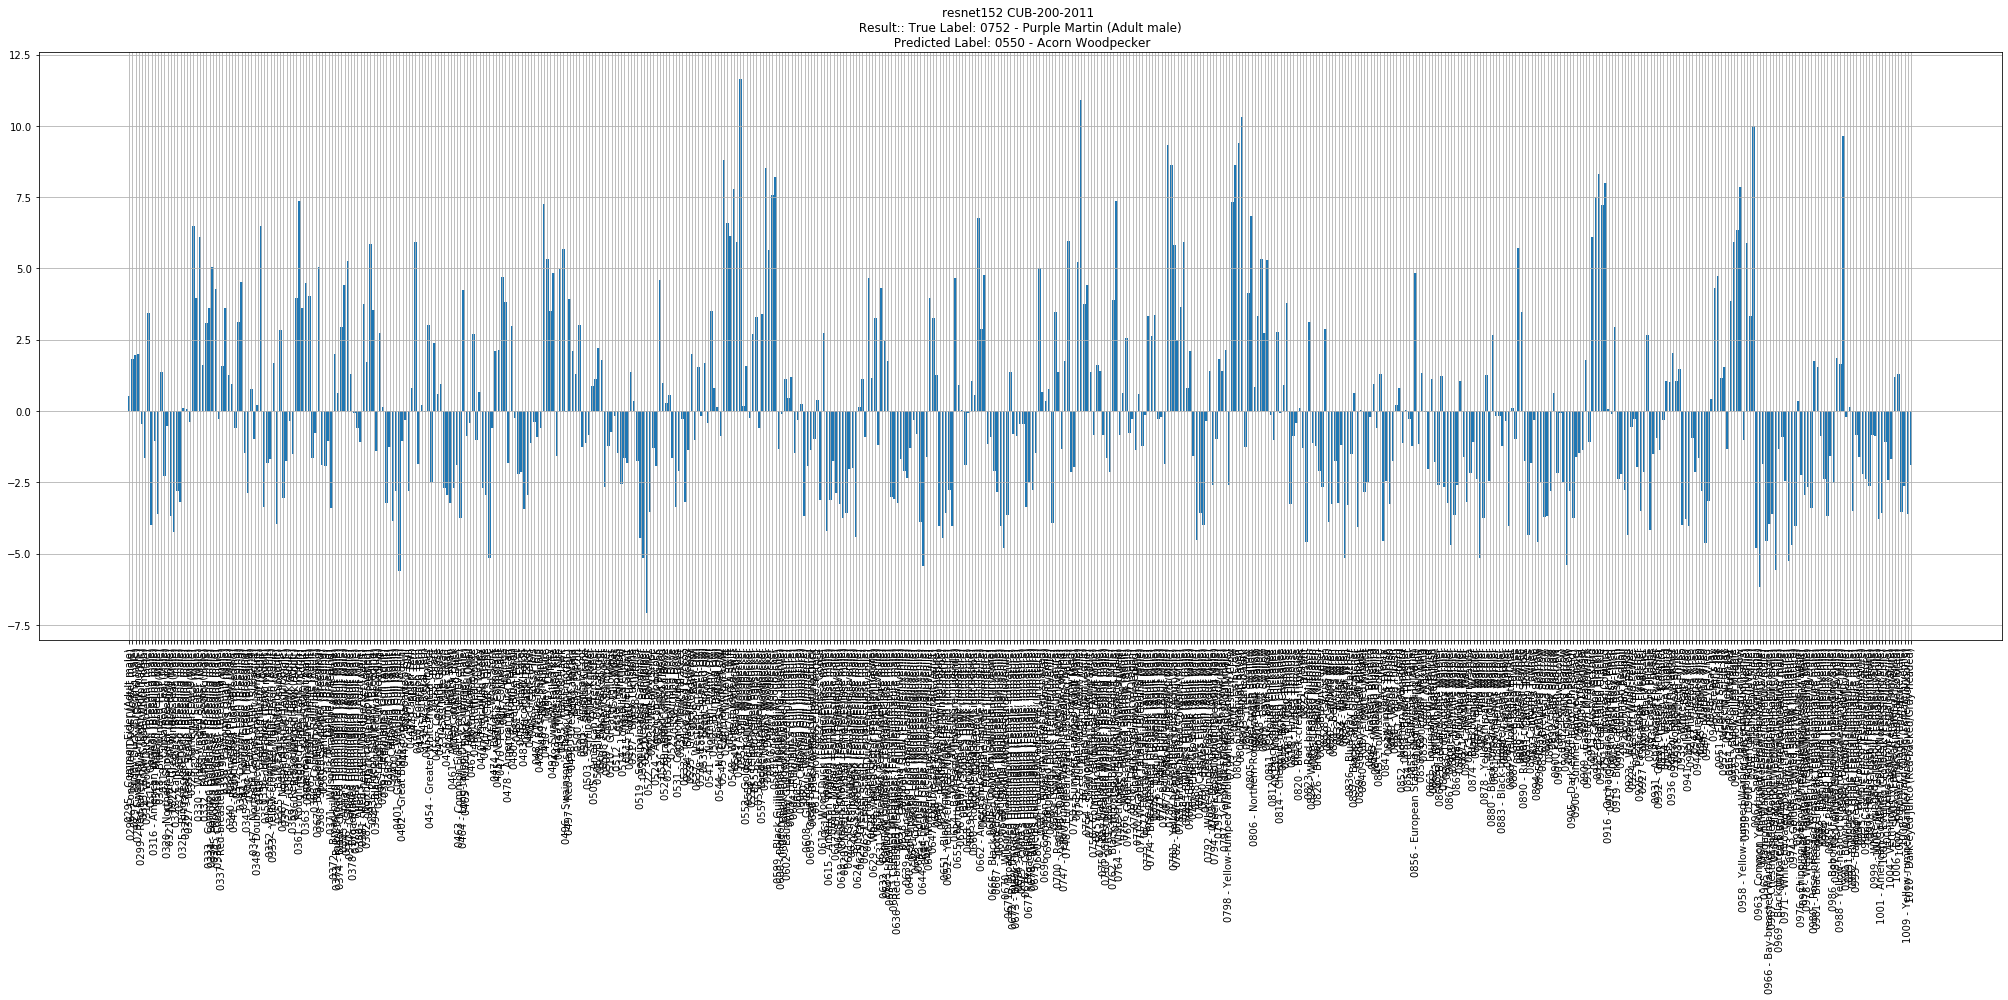

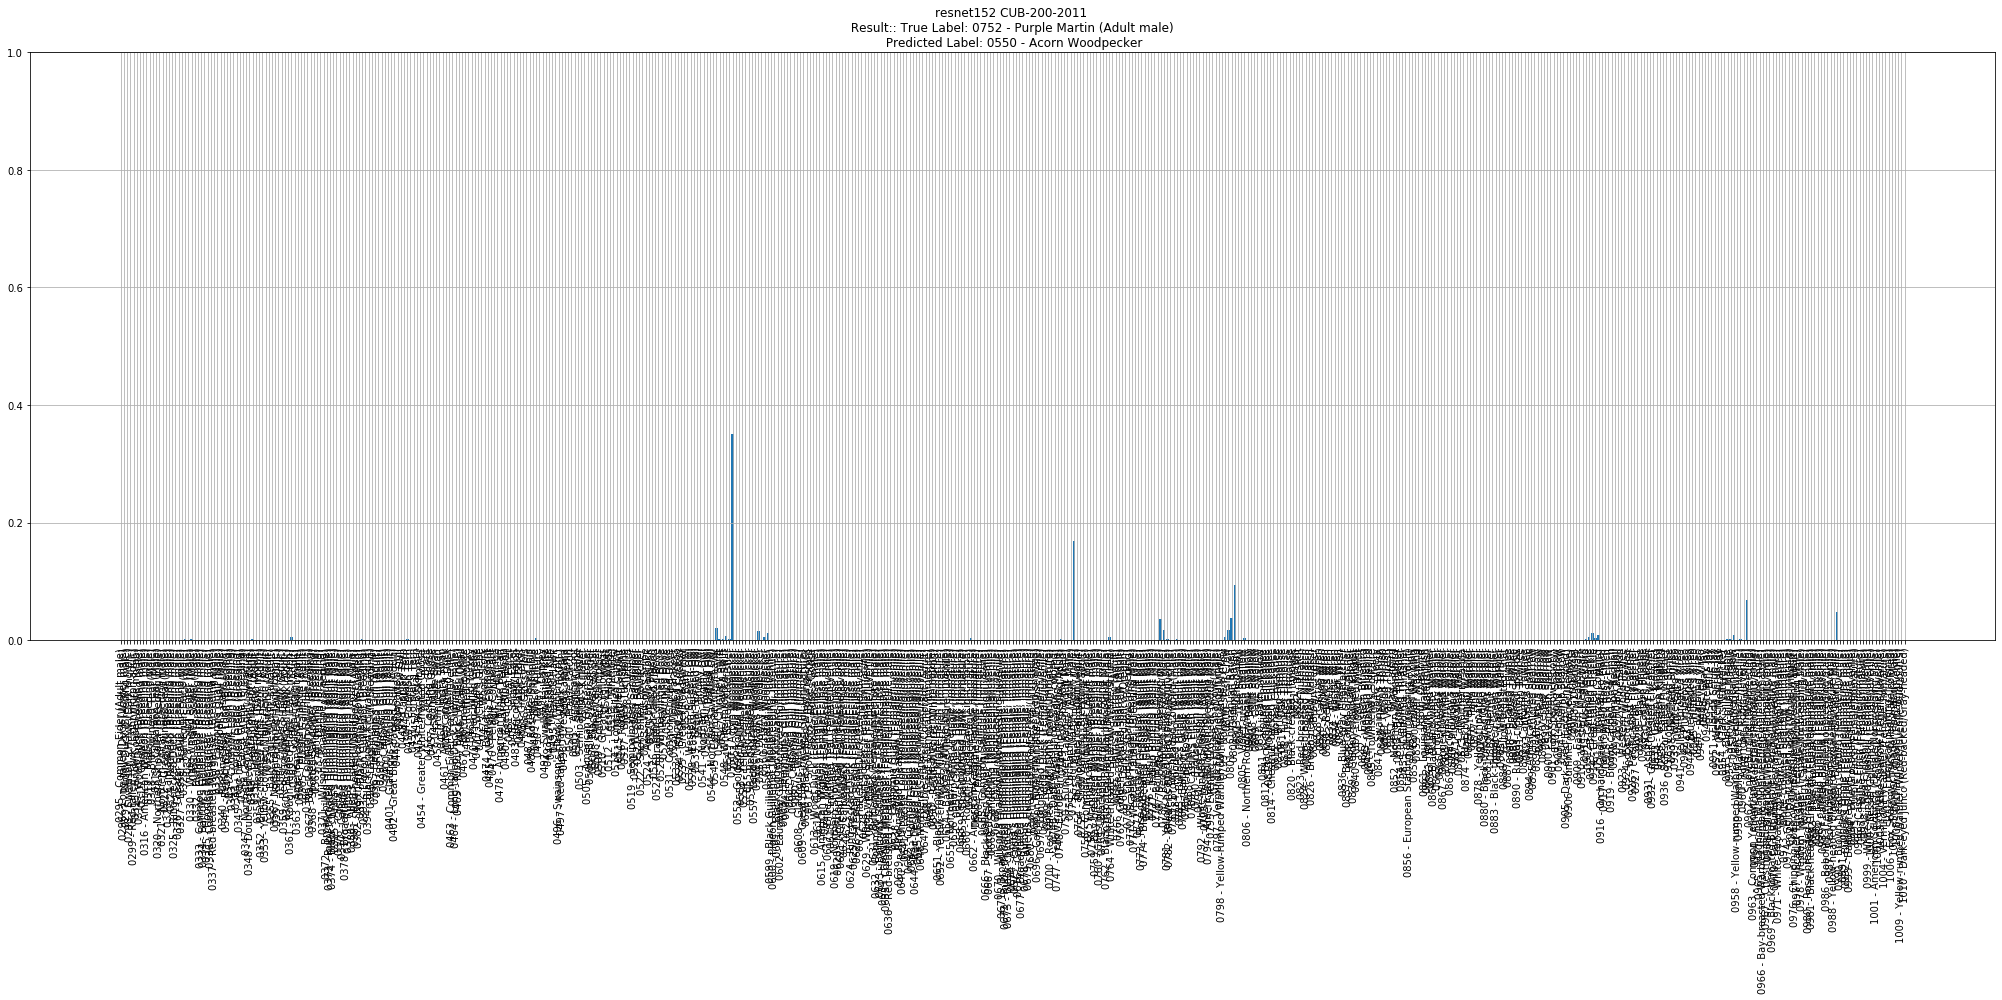

In [38]:
plt.figure(figsize=(28,14))
plt.bar(class_names,height=results_dict['scores pred'][test_img_i])
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(28,14))
plt.bar(class_names,height=results)
plt.xticks(rotation=90)
plt.title('{} CUB-200-2011 \n Result:: True Label: {} \n Predicted Label: {}'.format(model, class_names[results_dict['labels truth'][test_img_i]], class_names[results_dict['labels pred'][test_img_i]]))
plt.grid(True)
plt.tight_layout()
plt.ylim([0.0, 1.0])
plt.show()